In [2]:
# interactive figure
%matplotlib widget

# auto reload modules
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
data_root = '~/Projects/TRACE-SEAS/FrontalZone/'
east = xr.open_dataset(data_root+'frontal_zone_east_slice.nc').load()
south = xr.open_dataset(data_root+'frontal_zone_south_slice.nc').load()
top = xr.open_dataset(data_root+'frontal_zone_top_slice.nc').load()

In [62]:
south

<xarray.Dataset>
Dimensions:  (zC: 16, zF: 17, xC: 128, yF: 1, xF: 128, yC: 1, time: 41)
Coordinates:
  * zC       (zC) float64 -131.9 -117.2 -105.0 -94.83 ... -18.23 -10.94 -3.646
  * zF       (zF) float64 -140.0 -123.8 -110.5 -99.56 ... -14.59 -7.293 0.0
  * xC       (xC) float64 -496.1 -488.3 -480.5 -472.7 ... 480.5 488.3 496.1
  * yF       (yF) float64 0.0
  * xF       (xF) float64 -500.0 -492.2 -484.4 -476.6 ... 476.6 484.4 492.2
  * yC       (yC) float64 3.906
  * time     (time) timedelta64[ns] 0 days 00:00:00 ... 20 days 00:00:00
Data variables:
    v        (time, zC, yF, xC) float64 -0.001036 -0.0003256 ... -0.003516
    w        (time, zF, yC, xC) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b        (time, zC, yC, xC) float64 1.454e-05 1.454e-05 ... 2.509e-05
    u        (time, zC, yC, xF) float64 -0.0005211 -0.0005365 ... -0.00338
    ζ        (time, zC, yF, xF) float64 -0.0001525 0.0002058 ... 5.285e-05
Attributes:
    interval:              43200.0
    Oceananigans:          This file was generated using Oceananigans v0.88.0
    Julia:                 This file was generated using Julia Version 1.9.1\...
    output time interval:  Output was saved every 12 hours.
    date:                  This file was generated on 2023-09-26T09:34:07.322.
    schedule:              TimeInterval

In [74]:
X, Y, Z = np.meshgrid(south.xC, east.yC, east.zC)

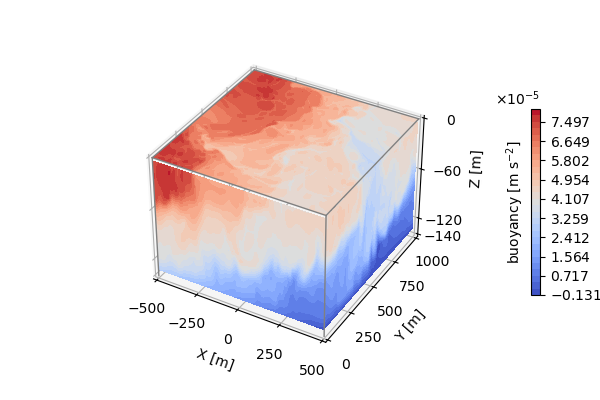

In [112]:
# Define dimensions
Nx, Ny, Nz = 128, 128, 16
X, Y, Z = np.meshgrid(south.xC, east.yC, east.zC)

itime = 25
Bbak = -3e-8*X
bmin = min([(top.b.isel(time=itime,zC=0).transpose('xC','yC') + Bbak[:,:,-1]).min(), 
            (east.b.isel(time=itime,xC=0).transpose('yC','zC') + Bbak[:,-1,:]).min(), 
            (south.b.isel(time=itime,yC=0).transpose('xC','zC') + Bbak[0,:,:]).min()])
bmax = max([(top.b.isel(time=itime,zC=0).transpose('xC','yC') + Bbak[:,:,-1]).max(), 
            (east.b.isel(time=itime,xC=0).transpose('yC','zC') + Bbak[:,-1,:]).max(), 
            (south.b.isel(time=itime,yC=0).transpose('xC','zC') + Bbak[0,:,:]).max()])
kw = {
    'vmin': bmin,
    'vmax': bmax,
    'levels': np.linspace(bmin, bmax, 30),
    'cmap': 'coolwarm'
}

# Create a figure with 3D ax
plt.close()
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, -1], Y[:, :, -1], top.b.isel(time=itime,zC=0).transpose('yC','xC') + Bbak[:,:,-1],
    zdir='z', offset=0, **kw
)
_ = ax.contourf(
    X[0, :, :], south.b.isel(time=itime,yC=0).transpose('xC','zC') + Bbak[0,:,:], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    east.b.isel(time=itime,xC=0).transpose('yC','zC') + Bbak[:,-1,:], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --


# Set limits of the plot from coord limits
xmin, xmax = -500, 500
ymin, ymax = 0, 1000
zmin, zmax = -140, 0
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='gray', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymax], [zmax, zmax], **edges_kw)
ax.plot([xmin, xmax], [ymax, ymax], [zmax, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
    zticks=[0, -60, -120, -140],
    xticks=[-500, -250, 0, 250, 500],
    yticks=[0, 250, 500, 750, 1000]
)

# Set zoom and angle view
ax.view_init(35, -60, 0)
ax.set_box_aspect(None, zoom=1)

# Colorbar
cbar = fig.colorbar(C, ax=ax, fraction=0.02, pad=0.2)
cbar.set_label(r'buoyancy [m s$^{-2}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

# Show Figure
# plt.show()
# plt.savefig('Figures/b3d_initial.png', dpi=150)
plt.savefig('Figures/b3d_mid.png', dpi=150)